In [19]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from numpy.linalg import inv
from numpy.linalg import det
from numpy.linalg import eig

import tensorflow as tf
import tensorflow_probability as tfp

import gpflow



In [20]:
def cholesky_with_jitter(K, jitter):
    k_diag = tf.linalg.diag_part(K)
    jitter_diag = tf.fill(tf.shape(k_diag), tf.cast(jitter, dtype=K.dtype))
    jittered_K = tf.linalg.set_diag(K, k_diag + jitter_diag)
    return tf.linalg.cholesky(jittered_K)

K1 = gpflow.kernels.SquaredExponential(variance=1, lengthscales=5)

pi = tf.cast(np.pi, tf.float64)

noise = tf.cast(1, tf.float64)

In [21]:
N = 100
M = 30

In [22]:
Xs = np.linspace(1, 10, 100).reshape(-1,1)
X = np.random.uniform(1, 10, N).reshape(-1,1)
Y = 5*np.sin(X)

Z1 = X[0:M]

In [23]:
m1 = tf.Variable(np.zeros(M).reshape(-1,1))
S1 = tf.Variable(np.identity(M))

In [24]:
def elbo(m1,S1):
    
    likelihood_GP = 0
    inv_K_Z1Z1 = inv(  cholesky_with_jitter(K1(Z1,Z1),1e-10)@tf.transpose(cholesky_with_jitter(K1(Z1,Z1),1e-10)))
    

    for i in range (0,N):
        f1_sample_mean = tf.linalg.matmul(tf.linalg.matmul(K1(X[i].reshape(-1,1),Z1),inv_K_Z1Z1),m1)
        f1_sample_covariance = K1(X[i].reshape(-1,1),X[i].reshape(-1,1))-tf.linalg.matmul(tf.linalg.matmul(K1(X[i].reshape(-1,1),Z1),inv_K_Z1Z1),K1(Z1,X[i].reshape(-1,1)))+tf.linalg.matmul(tf.linalg.matmul(tf.linalg.matmul(tf.linalg.matmul(K1(X[i].reshape(-1,1),Z1),inv_K_Z1Z1),S1@tf.transpose(S1)),inv_K_Z1Z1),K1(Z1,X[i].reshape(-1,1)))
        f1_sample = tf.math.reduce_mean(tfp.distributions.Normal(f1_sample_mean,f1_sample_covariance).sample(100))
        
        likelihood =tf.math.multiply(tf.cast(-1/2,tf.float64),tf.math.log(tf.math.multiply(tf.cast(2,tf.float64),tf.math.multiply(pi,tf.math.square(noise))))) - tf.math.divide(tf.math.square((Y[i]-f1_sample)),tf.math.square(noise))
        likelihood_GP = likelihood_GP + likelihood
      
   
    KL1 = tf.math.multiply(tf.cast(-1/2,tf.float64),(tf.linalg.trace(tf.linalg.matmul(inv_K_Z1Z1,S1@tf.transpose(S1)))+tf.linalg.matmul(tf.linalg.matmul(tf.transpose(m1),inv_K_Z1Z1),m1)-M+tf.math.log(tf.linalg.det(cholesky_with_jitter(K1(Z1,Z1),1e-5)))-tf.math.log(tf.linalg.det(S1@tf.transpose(S1)))))
   
    KL_GP = KL1
    
    elbo =  (likelihood_GP - KL_GP)



    return elbo

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1)
for i in range(500):
    with tf.GradientTape() as tape:
        objective = elbo(m1,S1)
        gradients = tape.gradient(objective, [m1,S1])
    print(i, "objective:", objective)
    optimizer.apply_gradients(zip(gradients, [m1,S1]))

0 objective: tf.Tensor([[1.04324667e+11]], shape=(1, 1), dtype=float64)
1 objective: tf.Tensor([[2.26537627e+12]], shape=(1, 1), dtype=float64)
2 objective: tf.Tensor([[6.07753502e+11]], shape=(1, 1), dtype=float64)
3 objective: tf.Tensor([[8.40596442e+11]], shape=(1, 1), dtype=float64)
4 objective: tf.Tensor([[1.07224247e+12]], shape=(1, 1), dtype=float64)
5 objective: tf.Tensor([[7.76729457e+11]], shape=(1, 1), dtype=float64)
6 objective: tf.Tensor([[4.71343619e+11]], shape=(1, 1), dtype=float64)
7 objective: tf.Tensor([[3.84515543e+11]], shape=(1, 1), dtype=float64)
8 objective: tf.Tensor([[4.42304461e+11]], shape=(1, 1), dtype=float64)
9 objective: tf.Tensor([[4.52731126e+11]], shape=(1, 1), dtype=float64)
10 objective: tf.Tensor([[3.68603063e+11]], shape=(1, 1), dtype=float64)
11 objective: tf.Tensor([[2.77455793e+11]], shape=(1, 1), dtype=float64)
12 objective: tf.Tensor([[2.50183618e+11]], shape=(1, 1), dtype=float64)
13 objective: tf.Tensor([[2.6804129e+11]], shape=(1, 1), dtyp

112 objective: tf.Tensor([[41100170.92813731]], shape=(1, 1), dtype=float64)
113 objective: tf.Tensor([[53136397.81278411]], shape=(1, 1), dtype=float64)
114 objective: tf.Tensor([[47619184.61108529]], shape=(1, 1), dtype=float64)
115 objective: tf.Tensor([[54666953.37383397]], shape=(1, 1), dtype=float64)
116 objective: tf.Tensor([[90776992.9193691]], shape=(1, 1), dtype=float64)
117 objective: tf.Tensor([[1.67064924e+08]], shape=(1, 1), dtype=float64)
118 objective: tf.Tensor([[2.86643457e+08]], shape=(1, 1), dtype=float64)
119 objective: tf.Tensor([[2.74832247e+08]], shape=(1, 1), dtype=float64)
120 objective: tf.Tensor([[1.46276478e+08]], shape=(1, 1), dtype=float64)
121 objective: tf.Tensor([[1.91884012e+08]], shape=(1, 1), dtype=float64)
122 objective: tf.Tensor([[2.01401322e+08]], shape=(1, 1), dtype=float64)
123 objective: tf.Tensor([[54810375.30109101]], shape=(1, 1), dtype=float64)
124 objective: tf.Tensor([[1.13989397e+08]], shape=(1, 1), dtype=float64)
125 objective: tf.Ten

222 objective: tf.Tensor([[2.33105581e+08]], shape=(1, 1), dtype=float64)
223 objective: tf.Tensor([[73870766.25666177]], shape=(1, 1), dtype=float64)
224 objective: tf.Tensor([[1.19697714e+08]], shape=(1, 1), dtype=float64)
225 objective: tf.Tensor([[2.0766394e+08]], shape=(1, 1), dtype=float64)
226 objective: tf.Tensor([[1.3709022e+08]], shape=(1, 1), dtype=float64)
227 objective: tf.Tensor([[1.99215417e+08]], shape=(1, 1), dtype=float64)
228 objective: tf.Tensor([[2.59390113e+08]], shape=(1, 1), dtype=float64)
229 objective: tf.Tensor([[1.47624952e+08]], shape=(1, 1), dtype=float64)
230 objective: tf.Tensor([[94437716.4791313]], shape=(1, 1), dtype=float64)
231 objective: tf.Tensor([[80716992.74078283]], shape=(1, 1), dtype=float64)
232 objective: tf.Tensor([[86552671.72903307]], shape=(1, 1), dtype=float64)
233 objective: tf.Tensor([[1.49329676e+08]], shape=(1, 1), dtype=float64)
234 objective: tf.Tensor([[96682077.53506888]], shape=(1, 1), dtype=float64)
235 objective: tf.Tensor([

333 objective: tf.Tensor([[1.93744201e+08]], shape=(1, 1), dtype=float64)
334 objective: tf.Tensor([[2.02331386e+08]], shape=(1, 1), dtype=float64)
335 objective: tf.Tensor([[3.60286162e+08]], shape=(1, 1), dtype=float64)
336 objective: tf.Tensor([[5.21531053e+08]], shape=(1, 1), dtype=float64)
337 objective: tf.Tensor([[4.94794329e+08]], shape=(1, 1), dtype=float64)
338 objective: tf.Tensor([[2.75254597e+08]], shape=(1, 1), dtype=float64)
339 objective: tf.Tensor([[1.67246788e+08]], shape=(1, 1), dtype=float64)
340 objective: tf.Tensor([[2.91006473e+08]], shape=(1, 1), dtype=float64)
341 objective: tf.Tensor([[3.25319154e+08]], shape=(1, 1), dtype=float64)
342 objective: tf.Tensor([[2.10746186e+08]], shape=(1, 1), dtype=float64)
343 objective: tf.Tensor([[3.01461584e+08]], shape=(1, 1), dtype=float64)
344 objective: tf.Tensor([[5.23439334e+08]], shape=(1, 1), dtype=float64)
345 objective: tf.Tensor([[6.04803435e+08]], shape=(1, 1), dtype=float64)
346 objective: tf.Tensor([[7.38047668e

444 objective: tf.Tensor([[2.9542611e+08]], shape=(1, 1), dtype=float64)
445 objective: tf.Tensor([[3.57978075e+08]], shape=(1, 1), dtype=float64)
446 objective: tf.Tensor([[3.64987252e+08]], shape=(1, 1), dtype=float64)
447 objective: tf.Tensor([[3.2459488e+08]], shape=(1, 1), dtype=float64)
448 objective: tf.Tensor([[3.12558535e+08]], shape=(1, 1), dtype=float64)
449 objective: tf.Tensor([[3.4726318e+08]], shape=(1, 1), dtype=float64)
450 objective: tf.Tensor([[3.6315044e+08]], shape=(1, 1), dtype=float64)
451 objective: tf.Tensor([[3.00708674e+08]], shape=(1, 1), dtype=float64)
452 objective: tf.Tensor([[1.9011855e+08]], shape=(1, 1), dtype=float64)
453 objective: tf.Tensor([[1.47137576e+08]], shape=(1, 1), dtype=float64)
454 objective: tf.Tensor([[2.15487407e+08]], shape=(1, 1), dtype=float64)
455 objective: tf.Tensor([[2.92947978e+08]], shape=(1, 1), dtype=float64)
456 objective: tf.Tensor([[2.76956246e+08]], shape=(1, 1), dtype=float64)
457 objective: tf.Tensor([[2.31703721e+08]]

In [26]:
inv_K_Z1Z1 = inv(  cholesky_with_jitter(K1(Z1,Z1),1e-10)@tf.transpose(cholesky_with_jitter(K1(Z1,Z1),1e-10)))
f1_sample_mean = np.matmul(np.matmul(K1(Xs,Z1),inv_K_Z1Z1),m1)
f1_sample_covariance = K1(Xs,Xs)-np.matmul(np.matmul(K1(Xs,Z1),inv_K_Z1Z1),K1(Z1,Xs))+np.matmul(np.matmul(np.matmul(np.matmul(K1(Xs,Z1),inv_K_Z1Z1),S1@tf.transpose(S1)),inv_K_Z1Z1),K1(Z1,Xs))
f1_samples = np.random.multivariate_normal(f1_sample_mean.reshape(100,), f1_sample_covariance, 10)



/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  after removing the cwd from sys.path.


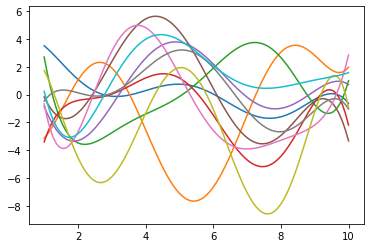

In [27]:
fig = plt.figure()
ax = plt.axes()
ax.plot(Xs,f1_samples.T)